# Example workflow of tools in the OpenSense software ecosystem

In [1]:
import matplotlib.pyplot as plt

import poligrain as plg
import pypwsqc
import mergeplg
import pycomlink as pycml

/Users/chwala-c/code/opensense_software_ecosystem_example/.conda/lib/python3.12/site-packages/pycomlink/io/examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Load open OpenMRG example data and project coordinates

We load 8 days of the OpenMRG dataset and do some quick visualization of the data using `poligrain`.

In [2]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [3]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

# gauges
ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# CMLs
ds_cmls.coords["site_0_x"], ds_cmls.coords["site_0_y"] = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
ds_cmls.coords["site_1_x"], ds_cmls.coords["site_1_y"] = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Radar
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = plg.spatial.project_point_coordinates(
    ds_rad.lon, ds_rad.lat, ref_str
)

<Axes: xlabel='lon', ylabel='lat'>

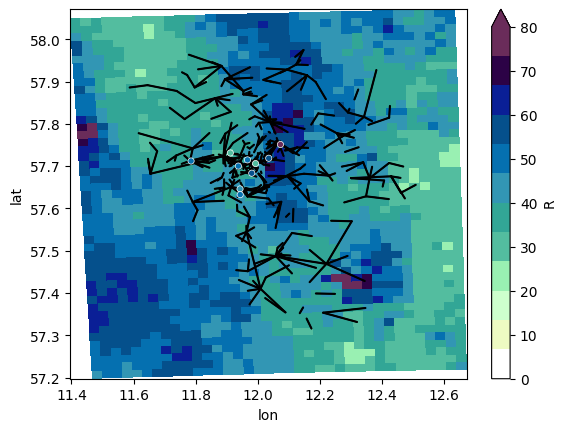

In [5]:
from matplotlib.colors import ListedColormap
import numpy as np

colors = {
    "precip4_11lev": [[254.0,254.0,254.0],[223.0,255.0,249.0],[154.0,217.0,202.0],[103.0,194.0,163.0],[64.0,173.0,117.0],[50.0,166.0,150.0],[90.0,160.0,205.0],[66.0,146.0,199.0],[76.0,141.0,196.0],[7.0,47.0,107.0],[7.0,30.0,70.0],[76.0,0.0,115.0]],
    "precip_11lev":[[255.0,255.0,255.0],[237.0,250.0,194.0],[205.0,255.0,205.0],[153.0,240.0,178.0],[83.0,189.0,159.0],[50.0,166.0,150.0],[50.0,150.0,180.0],[5.0,112.0,176.0],[5.0,80.0,140.0],[10.0,31.0,150.0],[44.0,2.0,70.0],[106.0,44.0,90.0]],
    "precip_diff_12lev":[[182.0,106.0,40.0],[205.0,133.0,63.0],[225.0,165.0,100.0],[245.0,205.0,132.0],[245.0,224.0,158.0],[255.0,245.0,186.0],[255.0,255.0,255.0],[205.0,255.0,205.0],[153.0,240.0,178.0],[83.0,189.0,159.0],[110.0,170.0,200.0],[5.0,112.0,176.0],[2.0,56.0,88.0]],
}

def cmap(name):
    data = np.array(colors[name])
    data = data / np.max(data)
    cmap = ListedColormap(data, name=name)
    return cmap

plg.plot_map.plot_plg(
    da_grid=ds_rad.R.resample(time='1h').mean().sum(dim="time"),
    da_gauges=ds_gauges_municp.rainfall_amount.sum(dim='time'),
    da_cmls=ds_cmls,
    vmin=0,
    vmax=80,
    cmap=cmap('precip_11lev'),
    kwargs_cmls_plot={"line_color": "k", "line_width": 1},
    kwargs_gauges_plot={"edge_color": 'w'},
)

## CML processing

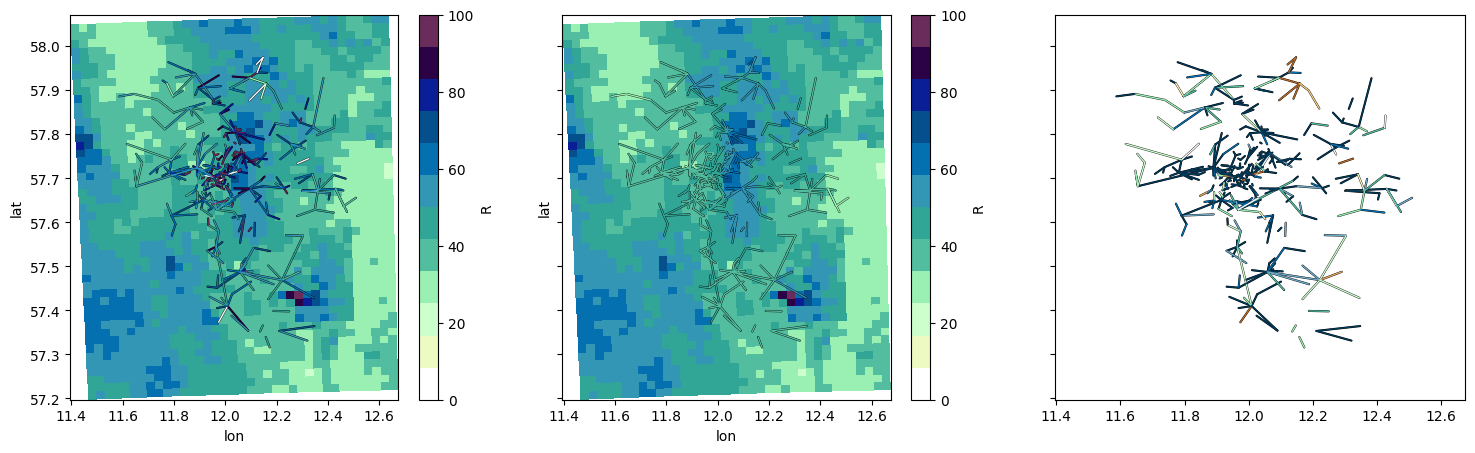

In [6]:
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl

# get radar along CMLs
grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad.R,
    ds_line_data=ds_cmls,
)
da_radar_along_cmls = grid_at_lines(ds_rad.R)

# wet-dry classification based on smoothed radar rain rates along each CML
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=6*3, center=True).max()
ds_cmls['wet'] = ds_cmls.wet.ffill(dim='time')

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=4,
    zeta=0.7,
    d=0.15,
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,
    f_GHz=ds_cmls.frequency / 1000,
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.1] = 0

# Calcualte rainfall sums for plotting
rad_sum = ds_rad.R.resample(time='1h').mean().sum(dim='time')
cml_sum = ds_cmls.R.isel(sublink_id=0).resample(time='1h').mean().sum(dim='time')
rad_along_cml_sum = da_radar_along_cmls.resample(time='1h').mean().sum(dim='time')

# Plot data on maps
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

plg.plot_map.plot_plg(
    da_grid=rad_sum,
    da_cmls=cml_sum, 
    vmin=0, 
    vmax=100,
    cmap=cmap('precip_11lev'),
    ax=axs[0],
    kwargs_cmls_plot={"line_width": 1},
)
plg.plot_map.plot_plg(
    da_grid=rad_sum,
    da_cmls=rad_along_cml_sum,
    kwargs_cmls_plot={"line_width": 1},
    vmin=0, 
    vmax=100,
    cmap=cmap('precip_11lev'),
    ax=axs[1],
)
plg.plot_map.plot_plg(
    #da_grid=rad_sum,
    da_cmls=cml_sum - rad_along_cml_sum,
    kwargs_cmls_plot={"line_width": 1, "vmin": -20, "vmax": 20, "cmap": cmap('precip_diff_12lev'),},
    vmin=0, 
    vmax=100,
    cmap="Grays",
    ax=axs[2],
);

## Apply an outlier filter which was oroginally developed for PWS QC

In [7]:
# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [63]:
# some preprocessing
# TODO: improve/skip things here e.g. calc distance matrix with line-to-line function in poligrain (to be added)

import xarray as xr
import tqdm

distance_matrix = plg.spatial.calc_point_to_point_distances(ds_cmls, ds_cmls)

nbrs_not_nan = []
reference = []

max_distance = 10e3

for cml_id in tqdm.tqdm(ds_cmls.cml_id.data):
    neighbor_ids = distance_matrix.cml_id.data[
        (distance_matrix.sel(cml_id=cml_id) < max_distance)
        & (distance_matrix.sel(cml_id=cml_id) > 0)
    ]

    da_R_neighbor_cmls = ds_cmls.R.sel(cml_id=neighbor_ids)

    N = da_R_neighbor_cmls.notnull().sum(dim="cml_id")  # noqa: PD004
    nbrs_not_nan.append(N)

    median = da_R_neighbor_cmls.median(dim="cml_id")
    reference.append(median)

ds_cmls["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="cml_id")
ds_cmls["reference"] = xr.concat(reference, dim="cml_id")

100%|██████████| 364/364 [00:19<00:00, 18.69it/s]


In [64]:
ds_cmls.rename({'R': 'rainfall', 'cml_id': 'id'}).rainfall.to_dataset()

<xarray.Dataset> Size: 403MB
Dimensions:       (sublink_id: 2, id: 364, time: 69120)
Coordinates: (12/16)
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * id            (id) int64 3kB 10001 10002 10003 10004 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (id) float64 3kB 57.7 57.73 57.69 57.71 ... 57.65 57.66 57.71
    site_0_lon    (id) float64 3kB 12.0 11.98 11.97 11.97 ... 12.12 12.03 12.01
    site_1_lat    (id) float64 3kB 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    ...            ...
    site_0_x      (id) float64 3kB 6.785e+05 6.776e+05 ... 6.808e+05 6.792e+05
    site_0_y      (id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x      (id) float64 3kB 6.783e+05 6.77e+05 ... 6.772e+05 6.778e+05
    site_1_y      (id) float64 3kB 6.399e+06 6.402e+06 ... 6.391e+06 6.401e+06
    x             (id) float64 3kB 6.784e+05 6.773e+05 ... 6.79e+05 6.785e+05
    y             (id) float64 3kB 6.399e+06 6.402e+06 ... 6.393e+06 6.4e+06
Data variables:
    rainfall      (sublink_id, id, time) float64 403MB 0.0 0.0 0.0 ... 0.0 0.0

In [65]:
evaluation_period = 8064
mmatch = 200
gamma = 0.15
n_stat = 5
max_distance = 10e3

import numpy as np

ds_cmls["so_flag"] = xr.DataArray(
    np.ones((len(ds_cmls.cml_id), len(ds_cmls.time))) * -999, dims=("id", "time")
)
ds_cmls["median_corr_nbrs"] = xr.DataArray(
    np.ones((len(ds_cmls.cml_id), len(ds_cmls.time))) * -999, dims=("id", "time")
)
ds_cmls["gamma"] = xr.DataArray(
    np.ones((len(ds_cmls.cml_id), len(ds_cmls.time))) * gamma, dims=("id", "time")
)

pypwsqc.flagging.so_filter(
    ds_pws=ds_cmls.isel(sublink_id=0).rename({'R': 'rainfall', 'cml_id': 'id'}),
    distance_matrix=distance_matrix.rename({'cml_id': 'id'}),
    evaluation_period=evaluation_period,
    mmatch=mmatch,
    gamma=gamma,
    n_stat=n_stat,
    max_distance=max_distance,
)

<xarray.Dataset> Size: 3GB
Dimensions:           (id: 364, time: 69120)
Coordinates: (12/16)
    sublink_id        <U9 36B 'sublink_1'
  * id                (id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time              (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T2...
    site_0_lat        (id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon        (id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat        (id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    ...                ...
    site_0_x          (id) float64 3kB 6.785e+05 6.776e+05 ... 6.792e+05
    site_0_y          (id) float64 3kB 6.4e+06 6.402e+06 ... 6.394e+06 6.4e+06
    site_1_x          (id) float64 3kB 6.783e+05 6.77e+05 ... 6.778e+05
    site_1_y          (id) float64 3kB 6.399e+06 6.402e+06 ... 6.401e+06
    x                 (id) float64 3kB 6.784e+05 6.773e+05 ... 6.785e+05
    y                 (id) float64 3kB 6.399e+06 6.402e+06 ... 6.393e+06 6.4e+06
Data variables: (12/14)
    tsl               (time, id) float64 201MB ...
    rsl               (time, id) float64 201MB ...
    rainfall          (id, time) float64 201MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tl                (time, id) float64 201MB 47.0 41.0 35.1 ... 52.7 56.1 50.1
    wet               (time, id) float64 201MB nan nan nan nan ... 0.0 0.0 0.0
    baseline          (id, time) float64 201MB 47.0 47.0 47.0 ... 50.1 50.1 50.1
    ...                ...
    A                 (time, id) float64 201MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nbrs_not_nan      (id, time) int64 201MB 176 176 176 176 ... 177 177 177 177
    reference         (id, time) float64 201MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    so_flag           (id, time) float64 201MB -1.0 -1.0 -1.0 ... 0.0 0.0 0.0
    median_corr_nbrs  (id, time) float64 201MB 0.3645 0.3645 ... 0.2961 0.2961
    gamma             (id, time) float64 201MB 0.15 0.15 0.15 ... 0.15 0.15 0.15
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

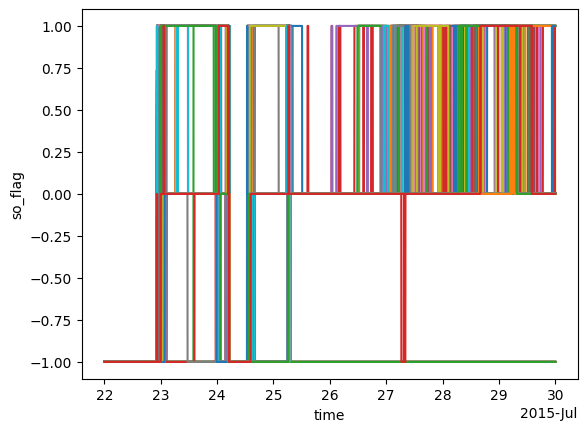

In [68]:
ds_cmls.so_flag.plot.line(x='time', add_legend=False);

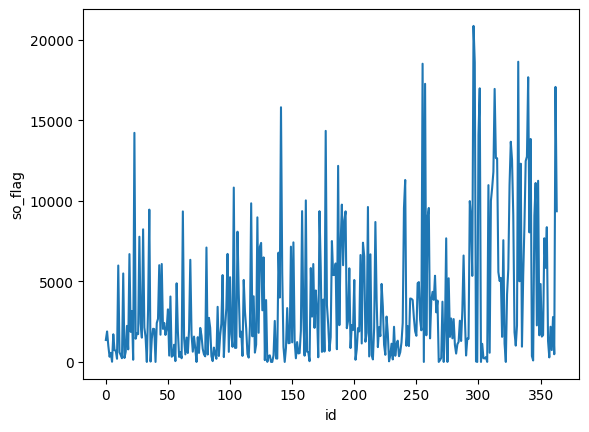

In [70]:
(ds_cmls.so_flag == 1).sum(dim='time').plot()

In [73]:
(ds_cmls.so_flag == 1).sum(dim='time').argmax()

<xarray.DataArray 'so_flag' ()> Size: 8B
np.int64(296)

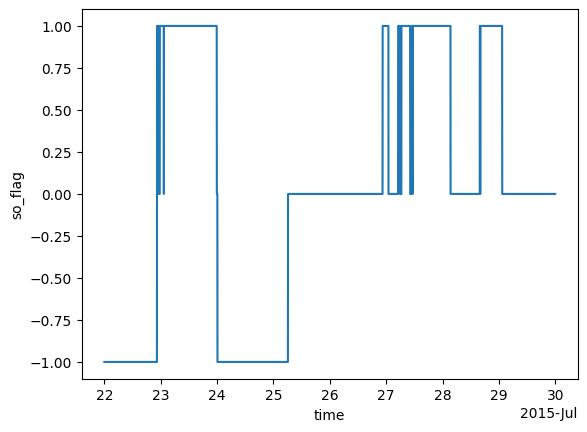

In [83]:
ds_cmls.so_flag.isel(id=296).plot()

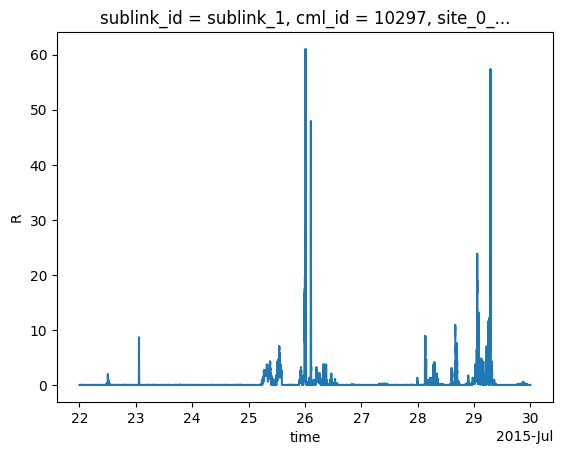

In [89]:
ds_cmls.isel(cml_id=296, sublink_id=0).R.plot()